# Capstone Notebook (Week5): The Battle of Neighborhoods in Houston -- Restaurants  
## Capstone Project for IBM Data Science Professional Certificate  
## Wenjun Hu, 02/18/2020

<img src="figures/skyline-houston.jpg" title="Houston"/>

### This is the notebook for the capstone project "The Battle of Neighborhoods in Houston".  
View map to use the following link:  
https://nbviewer.jupyter.org/github/phyhuhu/Coursera_Capstone/blob/master/Capstone_week5_notebook.ipynb

The project report is in the following link:  
https://nbviewer.jupyter.org/github/phyhuhu/Coursera_Capstone/blob/master/Capstone_week5_report.ipynb

The Linkedin Blog for this project is in the following link:  
https://www.linkedin.com/pulse/battle-neighborhoods-houston-restaurants-wenjun-hu

## Import Library

In [2]:
import pandas as pd
import numpy as np
import requests
import csv
import folium
import tabula
import json
import geopandas as gpd
import os
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### Downlaod the information of the super neighborhoods in Houston from the following link:  
https://cohgis-mycity.opendata.arcgis.com/datasets/coh-super-neighborhoods?geometry=-97.372%2C29.406%2C-93.458%2C30.240&page=9

I rename the csv file as "houston.csv":

In [3]:
df=pd.read_csv('houston.csv')
df.head()

,id,PERIMETER,POLYID,SNBNAME,GLOBALID,cohgisCOHGISSNBRAREA,cohgisCOHGISSNBRLEN,COUNCIL_ACTIVE,RECOGNITION_DATE,SnbrInfoURL,WeCan,Top10,CEA_FLAG,Shapearea,Shapelen
0,1,16572.025,60,FOURTH,{EDCA8617-F41A-4E57-8138-02BFCD50E562},0,0,NaN,NaN,http://www.houstontx.gov/superneighborhoods/60...,Y,NaN,N,1.296982e+07,16572.02602
1,2,43118.770,63,SECOND WARD,{C63DC59F-5080-4032-A84F-1660573E8BAA},0,0,Yes,2008-05-13T00:00:00.000Z,http://www.houstontx.gov/superneighborhoods/63...,Y,Y,Y,8.040472e+07,43118.77002
2,3,39256.388,61,DOWNTOWN,{F179E140-1B23-4A05-87A3-6BBBE0E510FF},0,0,NaN,NaN,http://www.houstontx.gov/superneighborhoods/61...,NaN,NaN,N,7.550023e+07,39256.38749
3,4,59784.698,59,CLINTON PARK,{F9FD0790-5903-444B-8485-8A18A7C14755},0,0,Yes,2000-11-20T00:00:00.000Z,http://www.houstontx.gov/superneighborhoods/59...,Y,NaN,Y,7.655352e+07,59784.69773
4,5,75759.390,21,UPTOWN,{5E8656DA-5291-4C40-B7D9-0C8D7F3A2D27},0,0,NaN,NaN,http://www.houstontx.gov/superneighborhoods/21...,NaN,NaN,N,2.297921e+08,75759.39014


### Download the information of the population for each super neighborhood in Houston:  
http://www.houstontx.gov/planning/Demographics/docs_pdfs/SN/Age_Total_Population.pdf

I grabbed the data of population of each super neighborhood from the pdf file and saved them into csv files:

In [4]:
# for page in range(1,5):
#     pdffile='Age_Total_Population.pdf'
#     csvfile='csv/Age_Total_Population_'+str(page)+'.csv'
#     tabula.convert_into(pdffile, csvfile, output_format="csv", pages=page)

popu_data_1=pd.read_csv('csv/Age_Total_Population_1.csv')
popu_data_2=pd.read_csv('csv/Age_Total_Population_2.csv')
popu_data_3=pd.read_csv('csv/Age_Total_Population_3.csv')
popu_data_4=pd.read_csv('csv/Age_Total_Population_4.csv')
popu_data=pd.concat([popu_data_1,popu_data_2,popu_data_3,popu_data_4])
popu_data.dropna(inplace=True)
popu_data.head()

,SN #,Super Neighborhood Name,Total,Under 5 Years,5 to 17 Years,18 to 64 Years,Over 65 Years
0,1.0,Willowbrook,"5,804",232,930,"4,109",533
1,2.0,Greater Greenspoint,"41,618","5,885","8,735","25,674","1,326"
2,3.0,Carverdale,"4,916",270,"1,015","3,255",376
3,4.0,Fairbanks / Northwest Crossing,"16,541","1,743","2,830","11,104",864
4,5.0,Greater Inwood,"30,890","2,688","6,558","19,573","2,071"


### Setup ID and secret of Foursquare

In [3]:
CLIENT_ID = '5WPVN0YFGC1NMY4PZX03J2CHM1HHKIJNBGMOTBHFHWG2G4UC'
CLIENT_SECRET = '3EUWS4GX2LR1VMPGVAL2GUOLOT1YANVEKZNZOSBABGN3UQOU'
VERSION = '20200217'

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: 5WPVN0YFGC1NMY4PZX03J2CHM1HHKIJNBGMOTBHFHWG2G4UC
CLIENT_SECRET:3EUWS4GX2LR1VMPGVAL2GUOLOT1YANVEKZNZOSBABGN3UQOU


### Get the latitude and longitude of Houston from Foursquare

In [4]:
city = 'Houston, USA'
geolocator = Nominatim(user_agent="foursquare_agent")
loc = geolocator.geocode(city)
lat_Houston = loc.latitude
lon_Houston = loc.longitude
print(city, lat_Houston, lon_Houston)

Houston, USA 29.7589382 -95.3676974


### I found some super neighborhoods that have different names between the above two links and Foursquare. So I had to clean them up manually, and I added two super neighborhoods: "Chinatown", which has many Chinese restaurants and is important for my later analysis, and "Energy Corridor" includes many oil & gas companies. I saved all data of super neighborhoods in the file houston_new_nei.csv:

In [34]:
houston_nei=pd.read_csv('houston_new_nei.csv')
houston_nei.head()

,Neighborhood
0,FOURTH
1,SECOND WARD
2,DOWNTOWN
3,CLINTON PARK
4,UPTOWN


### Get data of the latitude and longitude of each super neighborhood from Foursquare

In [35]:
lats=[]
lons=[]
for i in houston_nei['Neighborhood']:
    nei=i+', Houston, TX'
    loc = geolocator.geocode(nei)
    lats.append(loc.latitude)
    lons.append(loc.longitude)
#     print(nei,lats[-1],lons[-1])

### Combine the data of locations and populations for super neighborhoods to build one DataFrame "houston_data", and store it into houston_nei.csv. Then next time I just need to read all data to save time.

In [73]:
df_geo=pd.DataFrame([lats,lons])
df_geo=df_geo.T
df_geo.columns=['Latitude','Longitude']
po=popu_data['Total']
po=po.reset_index()
po.drop(['index'], axis=1, inplace=True)
houston_data= pd.concat([houston_nei['Neighborhood'], df_geo, po], axis=1)
houston_data.columns=['Neighborhood','Latitude','Longitude','Population']
# # houston_data.to_csv('houston_nei.csv')

In [5]:
houston_data=pd.read_csv('houston_nei.csv')
houston_data['Neighborhood']=houston_data['Neighborhood'].str.title()
houston_data.head()

,Neighborhood,Latitude,Longitude,Population
0,Fourth,29.918717,-95.516658,3975
1,Second Ward,29.747542,-95.340107,12297
2,Downtown,29.764282,-95.367413,12370
3,Clinton Park,29.740506,-95.257435,2422
4,Uptown,29.756611,-95.457673,48543


### The DataFrame "houston_data" has all super neighborhoods in Houston and includes the information of locations and populations for each neighborhood.

### Build the map of Houston with markers of 'Super Neighborhoods'

In [6]:
print('Super Neighborhoods with Population >=50000:',houston_data[houston_data['Population']>=50000].count()[0])
print('Super Neighborhoods with Population between 10000 and 49999:',houston_data[(houston_data['Population']>=10000) & (houston_data['Population']<50000)].count()[0])
print('Super Neighborhoods with Population <10000:',houston_data[houston_data['Population']<10000].count()[0])

Super Neighborhoods with Population >=50000: 11
Super Neighborhoods with Population between 10000 and 49999: 60
Super Neighborhoods with Population <10000: 19


In [7]:
map_Houston = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=10)

# add markers to map
for lat, lon, neighborhood, pop in zip(houston_data['Latitude'], houston_data['Longitude'], houston_data['Neighborhood'], houston_data['Population']):
    label = '{}, {}'.format(neighborhood, pop)
    label = folium.Popup(label, parse_html=True)

    if pop>=50000:
        co='blue'
        r=8
    elif pop>=10000:
        co='red'
        r=5
    else:
        co='green'
        r=3
        
    folium.CircleMarker(
        [lat, lon],
        radius=r,
        popup=label,
        color=co,
        fill=True,
        fill_color=co,
        fill_opacity=0.3,
        parse_html=False).add_to(map_Houston)

map_Houston

### Roughly, I divided the populations of super neighborhoods into three groups: Populations >= 50000, 50000 > Populations >= 10000, and Populations < 10000. In the map, I use the markers' sizes and colors to demonstrate the number of populations for super neighborhoods. 

##  The venues of super neighborhoods in Houston  
In the following, I will analyze the venues, especially the restaurants in Houston. I will first grab all venues for each super neighborhoods by their latitudes and longitudes from Foursquare. Then I will create the DataFrame for all venue categories including "Restaurant".

This function "_getNearbyVenues_" is for obtaining venues for super neighborhoods within 1000m from Foursquare and creating a DataFrame with all venues.

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    LIMIT=100
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
prevenues = getNearbyVenues(names=houston_data['Neighborhood'],
                                   latitudes=houston_data['Latitude'],
                                   longitudes=houston_data['Longitude']
                                  )

Fourth
Second Ward
Downtown
Clinton Park
Uptown
Inwood
Hobby Area
Golfcrest
West Oaks
Memorial Park
Fifth Ward
Denver Harbor
Pleasantville Area
Northshore
Lazybrook
The Heights
Kashmere Gardens
Minnetex
Near Northside
Spring Branch East
Spring Branch North
El Dorado
Spring Branch Central
Settegast
Langwood
Independence Heights
Central Northwest
Trinity / Houston Gardens
Carverdale
Eastex
East Houston
Acres Homes
Northside
Willowbrook
Greater Greenspoint
Airport Area
Kingwood Area
Lake Houston
Fairbanks / Northwest Crossing
Westbranch
Sharpstown
Westwood
Fort Bend Houston
Fondren Gardens
Southbelt
Crestmont Park
Central Southwest
Sunny Side
Alief
Pecan Park
Clear Lake City
Westbury
Willow Meadows
Braeburn
South Main
South Park
Astrodome Area
Park Place
Meadowbrook / Allendale
Texas Medical Center
Gulfton
Macgregor
Pine Valley
Harrisburg / Manchester
Westchase
Museum District
Lawndale
Upper Kirby Area
Third Ward
Eastwood
Midtown
Braeswood
Meyerland Area
Edgebrook Area
Magnolia Park
River

In [10]:
prevenues.shape

(2555, 7)

#### Delet the duplicate according to the same locations and categories of venues

In [11]:
venues=prevenues.drop_duplicates(subset =['Venue','Venue Latitude','Venue Longitude','Venue Category'],keep='first')
venues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2369 entries, 0 to 2554
Data columns (total 7 columns):
Neighborhood              2369 non-null object
Neighborhood Latitude     2369 non-null float64
Neighborhood Longitude    2369 non-null float64
Venue                     2369 non-null object
Venue Latitude            2369 non-null float64
Venue Longitude           2369 non-null float64
Venue Category            2369 non-null object
dtypes: float64(4), object(3)
memory usage: 148.1+ KB


In [12]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fourth,29.918717,-95.516658,Carriage House,29.925085,-95.517500,BBQ Joint
1,Fourth,29.918717,-95.516658,Hickory Hollow Restaurant and Catering,29.925428,-95.521963,American Restaurant
2,Fourth,29.918717,-95.516658,Alamo Bar & Grill,29.925547,-95.513104,Burger Joint
3,Fourth,29.918717,-95.516658,Alamo Bar & Grill,29.925693,-95.513148,Dive Bar
4,Fourth,29.918717,-95.516658,Alma's Cakes,29.925497,-95.511012,Bakery


### The DataFrame "_venues_" includes all locations and categories of venues for each super neighbor.

### Before I study the venues of restaurants in Houston, I would like to find venues that my family and I like, such as the gyms in Uptown, the shopping malls, and museums in Houston.  
#### Gyms in Uptown in Houston  
I would like to know the gyms in the Uptown near my apartment.

In [14]:
searchfor=['Gym', 'Fitness']
df_gym=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]

lat_up=df_gym[df_gym['Neighborhood']=='Uptown']['Neighborhood Latitude'].iloc[0]
lon_up=df_gym[df_gym['Neighborhood']=='Uptown']['Neighborhood Longitude'].iloc[0]
gym_Uptown = folium.Map(location=[lat_up, lon_up], zoom_start=13)

# add markers to map
for lat, lon, neighborhood in zip(df_gym['Venue Latitude'], df_gym['Venue Longitude'], df_gym['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    co='blue'
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=co,
        fill=True,
        fill_color=co,
        fill_opacity=0.3,
        parse_html=False).add_to(gym_Uptown)

gym_Uptown

#### Shopping Malls in Houston  
My wife likes shopping in malls, and there are some large shopping malls in Houston.

In [15]:
searchfor=['Mall']
df_mall=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]

map_mall = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

# add markers to map
for lat, lon, nei, venue in zip(df_mall['Venue Latitude'], df_mall['Venue Longitude'], df_mall['Neighborhood'], df_mall['Venue']):
    label = '{},{}'.format(nei,venue)
    label = folium.Popup(label, parse_html=True)
    co='blue'
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=co,
        fill=True,
        fill_color=co,
        fill_opacity=0.3,
        parse_html=False).add_to(map_mall)

map_mall

#### Museums in Houston  
My son likes to visit the museums in the Museum District.

In [16]:
searchfor=['Museum']
df_museums=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]

lat_mu=df_gym[df_gym['Neighborhood']=='Museum District']['Neighborhood Latitude'].iloc[0]
lon_mu=df_gym[df_gym['Neighborhood']=='Museum District']['Neighborhood Longitude'].iloc[0]
map_museums = folium.Map(location=[lat_mu, lon_mu], zoom_start=16)

# add markers to map
for lat, lon, nei, venue in zip(df_museums['Venue Latitude'], df_museums['Venue Longitude'], df_museums['Neighborhood'], df_museums['Venue']):
    label = '{},{}'.format(nei,venue)
    label = folium.Popup(label, parse_html=True)
    co='blue'
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=co,
        fill=True,
        fill_color=co,
        fill_opacity=0.3,
        parse_html=False).add_to(map_museums)

map_museums

### Check all venue categories

In [78]:
venues['Venue Category'].unique()

array(['BBQ Joint', 'American Restaurant', 'Burger Joint', 'Dive Bar',
       'Bakery', 'Bar', 'Brewery', 'Beer Garden', 'General Entertainment',
       'Mexican Restaurant', 'Coffee Shop', 'Music Venue', 'Park',
       'Food Truck', 'Discount Store', 'Convenience Store', 'Video Store',
       'Pizza Place', 'Supermarket', 'Flower Shop',
       'Gym / Fitness Center', 'Arts & Crafts Store', 'Grocery Store',
       'Theater', 'Concert Hall', 'Performing Arts Venue',
       'Sushi Restaurant', 'Dance Studio', 'Wine Bar',
       'Italian Restaurant', 'Southern / Soul Food Restaurant',
       'New American Restaurant', 'Beer Store', 'Aquarium', 'Hotel',
       'Farmers Market', 'Cocktail Bar', 'Beer Bar', 'Thai Restaurant',
       'Bistro', 'Greek Restaurant', 'Empanada Restaurant',
       'Theme Restaurant', 'Food Court', 'Trail', 'Gastropub',
       'Taco Place', 'Deli / Bodega', 'Latin American Restaurant',
       'Pharmacy', 'Café', 'Japanese Restaurant', 'Seafood Restaurant',
       '

### Select venues with "_Venue Category_" including "_Restaurant, Steakhouse, Noodle House_" to DataFrame "_df_".

In [79]:
searchfor=['Restaurant', 'Steakhouse','Noodle House']
df=venues[venues['Venue Category'].str.contains('|'.join(searchfor))==True]
df.shape

(534, 7)

### List all categories

In [80]:
df.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Afghan Restaurant,1,1,1,1,1,1
American Restaurant,38,38,38,38,38,38
Argentinian Restaurant,1,1,1,1,1,1
Asian Restaurant,16,16,16,16,16,16
Beijing Restaurant,1,1,1,1,1,1
Brazilian Restaurant,2,2,2,2,2,2
Cajun / Creole Restaurant,8,8,8,8,8,8
Caribbean Restaurant,3,3,3,3,3,3
Chinese Restaurant,40,40,40,40,40,40


### I find some categories ("_Xinjiang Restaurant_", "_Shanghai Restaurant_", "_Beijing Restaurant_", "_Szechuan Restaurant_", "_Hunan Restaurant_", and "_Hotpot Restaurant_") belong to "_Chinese Restaurant_". So I change their categories.

In [81]:
pd.set_option('mode.chained_assignment', None)

for i in df[df['Venue Category']=='Xinjiang Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Shanghai Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Beijing Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Szechuan Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Hunan Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'
for i in df[df['Venue Category']=='Hotpot Restaurant'].index:
    df['Venue Category'][i]='Chinese Restaurant'

In [82]:
df.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Afghan Restaurant,1,1,1,1,1,1
American Restaurant,38,38,38,38,38,38
Argentinian Restaurant,1,1,1,1,1,1
Asian Restaurant,16,16,16,16,16,16
Brazilian Restaurant,2,2,2,2,2,2
Cajun / Creole Restaurant,8,8,8,8,8,8
Caribbean Restaurant,3,3,3,3,3,3
Chinese Restaurant,51,51,51,51,51,51
Comfort Food Restaurant,6,6,6,6,6,6


### Personally, I like Chinese, Japanese, and Italian food. In the following map, we can find these three kinds of restaurants in Houston.

In [83]:
df_mine=df[(df['Venue Category']=='Chinese Restaurant') | (df['Venue Category']=='Japanese Restaurant') | (df['Venue Category']=='Italian Restaurant')]
map_res = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)
colors=['red','blue','green','orange','purple','darkred','lightred','beige','darkblue','darkgreen','cadetblue','darkpurple','white','pink','lightblue','lightgreen','gray','black','lightgray']
# add markers to map
for lat, lon, neighborhood, category in zip(df_mine['Venue Latitude'], df_mine['Venue Longitude'], df_mine['Venue'], df_mine['Venue Category']):
    label = '{}, {}'.format(neighborhood, category)
    label = folium.Popup(label, parse_html=True)
    if category=='Chinese Restaurant':
        co=0
    elif category=='Japanese Restaurant':
        co=1
    else:
        co=2
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=colors[co],
        fill=True,
        fill_color=colors[co],
        fill_opacity=0.3,
        parse_html=False).add_to(map_res)

map_res

### The bar plot for top 20 restaurant categories

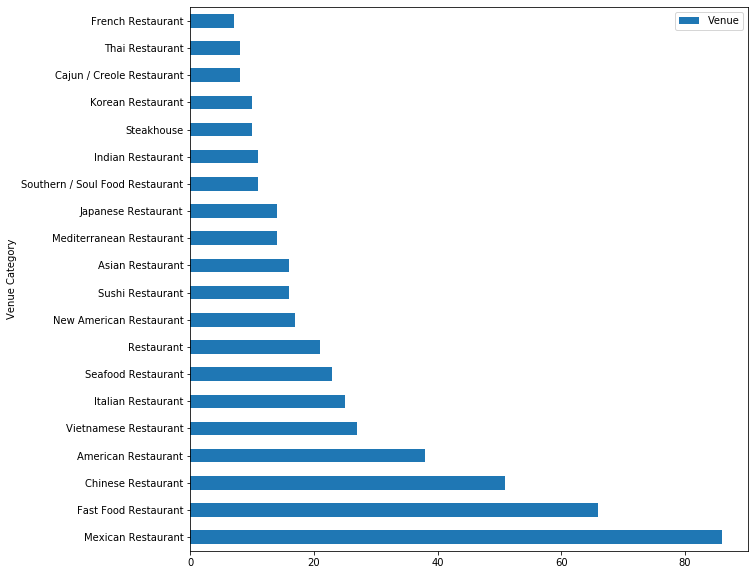

In [84]:
df1=df.groupby('Venue Category').count()
df1.sort_values(['Venue'], ascending=0, inplace=True)
df1.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], inplace=True)
df1.iloc[:20].plot.barh(figsize=(10,10))
plt.show()

### From this bar figure, the top 3 restaurants are "_Mexican_", "_Fast Food_", and "_Chinese_" restaurants in Houston.

## The K-means clustering for the restaurants in Houston

The first step is to change the DataFrame "_df_" to one hot encoding.

In [85]:
df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")
df_onehot.head()

,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### I choose the Elbow method to find the number of clusters. In the following, I do the K-means clustering up to k=9 clusters and plot the figure "Sum of square distance" vs. "Number of clusters *k*".

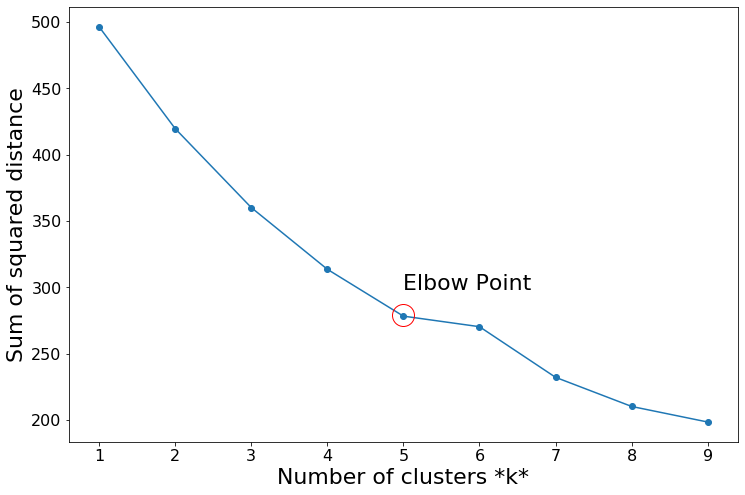

In [96]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df_onehot)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(12, 8))
plt.plot(list_k, sse, '-o')
plt.plot(5, 279, 'o', markersize=22, fillstyle='none', color='red')
plt.text(5, 310, 'Elbow Point',verticalalignment='top',multialignment='center',fontsize=22)
plt.xlabel(r'Number of clusters *k*', fontsize=22)
plt.ylabel('Sum of squared distance', fontsize=22)
plt.tick_params(axis='both',which='major',labelsize=16)

### From this figure, it is clear to find that the Elbow point is at k=5, which means the optimal number of clusters should be 5. So in the following analysis, I will use k=5 clusters.

In [107]:
# set the optimal number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_onehot)
kmeans.labels_[0:10]

array([0, 0, 1, 1, 1, 0, 1, 4, 0, 4], dtype=int32)

In [108]:
newdf=pd.DataFrame.merge(df,df_onehot,on=df.index)
newdf=newdf.set_index(['key_0'])
newdf.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Afghan Restaurant,American Restaurant,Argentinian Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
key_0,,,,,,,,,,,,,,,,,,,,,
1,Fourth,29.918717,-95.516658,Hickory Hollow Restaurant and Catering,29.925428,-95.521963,American Restaurant,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,Second Ward,29.747542,-95.340107,Champ Burger,29.749796,-95.340350,American Restaurant,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,Second Ward,29.747542,-95.340107,El Tiempo Cantina,29.756222,-95.341484,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,Second Ward,29.747542,-95.340107,Villa Arcos,29.755734,-95.339584,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,Second Ward,29.747542,-95.340107,Taquerias El Charro Mex,29.746691,-95.338020,Mexican Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Insert the label to the new DataFrame "_newdf_"

In [109]:
# add clustering labels
newdf.insert(0, 'Cluster Labels', kmeans.labels_)
newdf.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Afghan Restaurant,American Restaurant,...,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
key_0,,,,,,,,,,,,,,,,,,,,,
1,0,Fourth,29.918717,-95.516658,Hickory Hollow Restaurant and Catering,29.925428,-95.521963,American Restaurant,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,Second Ward,29.747542,-95.340107,Champ Burger,29.749796,-95.340350,American Restaurant,0,1,...,0,0,0,0,0,0,0,0,0,0
12,1,Second Ward,29.747542,-95.340107,El Tiempo Cantina,29.756222,-95.341484,Mexican Restaurant,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,Second Ward,29.747542,-95.340107,Villa Arcos,29.755734,-95.339584,Mexican Restaurant,0,0,...,0,0,0,0,0,0,0,0,0,0
23,1,Second Ward,29.747542,-95.340107,Taquerias El Charro Mex,29.746691,-95.338020,Mexican Restaurant,0,0,...,0,0,0,0,0,0,0,0,0,0


### List the categories for each cluster

In [129]:
for i in range(kclusters):
    print('Cluster=',i)
    print(newdf[newdf['Cluster Labels']==i]['Venue Category'].unique())

Cluster= 0
['American Restaurant' 'Sushi Restaurant'
 'Southern / Soul Food Restaurant' 'New American Restaurant'
 'Thai Restaurant' 'Greek Restaurant' 'Empanada Restaurant'
 'Theme Restaurant' 'Latin American Restaurant' 'Japanese Restaurant'
 'Seafood Restaurant' 'Steakhouse' 'Mediterranean Restaurant'
 'French Restaurant' 'Comfort Food Restaurant' 'Restaurant'
 'Cajun / Creole Restaurant' 'Vietnamese Restaurant' 'Asian Restaurant'
 'Indian Chinese Restaurant' 'Noodle House' 'Persian Restaurant'
 'Tapas Restaurant' 'Indian Restaurant' 'Caribbean Restaurant'
 'Afghan Restaurant' 'Spanish Restaurant' 'Hawaiian Restaurant'
 'Argentinian Restaurant' 'Korean Restaurant' 'Brazilian Restaurant'
 'Vegetarian / Vegan Restaurant' 'Middle Eastern Restaurant'
 'Modern European Restaurant' 'Ramen Restaurant' 'Dumpling Restaurant'
 'Cuban Restaurant' 'Turkish Restaurant' 'Dim Sum Restaurant'
 'Malay Restaurant' 'Taiwanese Restaurant']
Cluster= 1
['Mexican Restaurant']
Cluster= 2
['Fast Food Restau

## Houston Map with Clusters 0, 1, 2, 3, 4

In [130]:
# create map
map_clusters = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

colors=['orange','red','blue','green','purple','gray','black','darkred','darkblue','pink','beige','lightred','darkgreen','cadetblue','darkpurple','white','pink','lightblue','lightgreen','lightgray']

# add markers to the map
markers_colors = []

for nei, lat, lon, venue, category, cluster in zip(newdf['Neighborhood'],newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    pop=houston_data[houston_data['Neighborhood']==nei]['Population'].iloc[0]
    
    label = folium.Popup(nei+'-'+str(pop)+'-'+venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>=50000:
        r=8
    elif pop>=10000:
        r=5
    else:
        r=3
    
    if cluster!=-1:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.3).add_to(map_clusters)

map_clusters

## The Houston maps for each Cluster:

## Houston Map with Cluster 0

In [131]:
# create map
map_cluster0 = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

# add markers to the map
markers_colors = []
for nei, lat, lon, venue, category, cluster in zip(newdf['Neighborhood'],newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    pop=houston_data[houston_data['Neighborhood']==nei]['Population'].iloc[0]
    
    label = folium.Popup(nei+'-'+str(pop)+'-'+venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>=50000:
        r=8
    elif pop>=10000:
        r=5
    else:
        r=3
    
    if cluster==0:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.3).add_to(map_cluster0)

map_cluster0

## Houston Map with Cluster 1: Mexican Restaurant:

In [132]:
# create map
map_cluster1 = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

# add markers to the map
markers_colors = []
for nei, lat, lon, venue, category, cluster in zip(newdf['Neighborhood'],newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    pop=houston_data[houston_data['Neighborhood']==nei]['Population'].iloc[0]
    
    label = folium.Popup(nei+'-'+str(pop)+'-'+venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>=50000:
        r=8
    elif pop>=10000:
        r=5
    else:
        r=3
    
    if cluster==1:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.3).add_to(map_cluster1)

map_cluster1

## Houston Map with Cluster 2: Fast Food Restaurant:

In [133]:
# create map
map_cluster2 = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

# add markers to the map
markers_colors = []
for nei, lat, lon, venue, category, cluster in zip(newdf['Neighborhood'],newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    pop=houston_data[houston_data['Neighborhood']==nei]['Population'].iloc[0]
    
    label = folium.Popup(nei+'-'+str(pop)+'-'+venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>=50000:
        r=8
    elif pop>=10000:
        r=5
    else:
        r=3
    
    if cluster==2:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.3).add_to(map_cluster2)

map_cluster2

## Houston Map with Cluster 3: Chinese Restaurant:

In [134]:
# create map
map_cluster3 = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

# add markers to the map
markers_colors = []
for nei, lat, lon, venue, category, cluster in zip(newdf['Neighborhood'],newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    pop=houston_data[houston_data['Neighborhood']==nei]['Population'].iloc[0]
    
    label = folium.Popup(nei+'-'+str(pop)+'-'+venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>=50000:
        r=8
    elif pop>=10000:
        r=5
    else:
        r=3
    
    if cluster==3:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.3).add_to(map_cluster3)

map_cluster3

## Houston Map with Cluster 4: Italian Restaurant:

In [135]:
# create map
map_cluster4 = folium.Map(location=[lat_Houston, lon_Houston], zoom_start=11)

# add markers to the map
markers_colors = []
for nei, lat, lon, venue, category, cluster in zip(newdf['Neighborhood'],newdf['Venue Latitude'], newdf['Venue Longitude'], newdf['Venue'], newdf['Venue Category'], newdf['Cluster Labels']):
    pop=houston_data[houston_data['Neighborhood']==nei]['Population'].iloc[0]
    
    label = folium.Popup(nei+'-'+str(pop)+'-'+venue + '-' + category + ' Cluster ' + str(cluster), parse_html=True)
    
    if pop>=50000:
        r=8
    elif pop>=10000:
        r=5
    else:
        r=3
    
    if cluster==4:
        folium.CircleMarker(
            [lat, lon],
            radius=r,
            popup=label,
            color=colors[int(cluster)],  #rainbow[int(cluster)-1],
            fill=True,
            fill_color=colors[int(cluster)], #rainbow[int(cluster)-1],
            fill_opacity=0.3).add_to(map_cluster4)

map_cluster4